# Práctica 3 - Regresión logística multi-clase y redes neuronales

## Regresión logística multi-clase

### Visualización de los datos

In [1]:
import numpy as np

In [2]:
from  scipy.io import loadmat

In [3]:
data = loadmat('datasets/ex3data1.mat')

y = data['y']
X = data['X']
print(X.shape, y.shape)

(5000, 400) (5000, 1)


In [4]:
import matplotlib.pyplot as plt

[5 9 6 3 3 5 2 9 4 8]


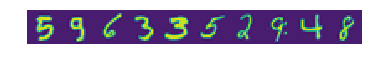

In [5]:
sample = np.random.choice(X.shape[0], 10)
plt.imshow(X[sample, :].reshape(-1, 20).T)
plt.axis('off')
print(np.ravel(y[sample]))

In [6]:
X = np.c_[np.ones(len(X)), X]
print(X.shape, X[:,0])

(5000, 401) [1. 1. 1. ... 1. 1. 1.]


### Vectorización de la regresión logística

La implementación de la función sigmoide sigue la siguiente expresión: $$g(z)= \frac{1}{1 + e^{-z}}$$ 

siendo   $h_{\theta}(x^{(i)}) = g(\theta^{T}x^{(i)}) $

In [7]:
def sigmoid_function(z):
    return 1/(1 + np.e**(-z))

#### Vectorización de la función de coste

_Función coste_$$J(\theta) = \frac{1}{m}((log(g(X\theta))^{T}(-y) - (log(1 - g(X\theta))^{T}(1-y))$$

In [8]:
def cost_function(th, X, y, fun):
    fun_evaluated_xth = fun(np.dot(X, th))
    cost = (1/len(X))*(np.log(fun_evaluated_xth).T.dot(-y) - np.log(1-fun_evaluated_xth).T.dot(1-y))
    return cost

#### Vectorización del gradiente

_Gradiente_$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}X^{T}(g(X\theta)-y) $$

In [9]:
def cost_gradient(th, fun, x, y, m):
    cg = (1/m)*x.T.dot(fun(np.dot(x, th)) - y)
    return cg

#### Cálculo de la versión regularizada

_Función coste_
$$J(\theta) = \frac{1}{m}((log(g(X\theta))^{T}(-y) - (log(1 - g(X\theta))^{T}(1-y)) + \frac{\lambda}{2m}\sum_{j=1}^{n}{\theta^{2}_{j}}$$

_Gradiente_
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}X^{T}(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$

In [47]:
def cost_function_opt(th, x, y, reg):
    def fun(z):
        return 1/(1 + np.e**(-z))

    fun_evaluated_xth = fun(np.dot(x, th))
    cost = -(1/len(X))*(np.log(fun_evaluated_xth).T.dot(y) 
                       + np.log(1-fun_evaluated_xth).T.dot(1-y)) + (reg/2*len(X))*np.sum(np.power(th, 2))
    return cost

def cost_gradient_opt(th, x, y, reg):
    def fun(z):
        return 1/(1 + np.e**(-z))
    
    cg = (1/len(x))*x.T.dot(fun(np.dot(x, th)) - y) + th*reg/len(X)
    return cg

### Clasificación de uno frente a todos

In [11]:
import scipy.optimize as opt

In [48]:
def oneVsAll(th, X, y, num_labels, reg):
    th_ret = []
    for i in range(1, num_labels + 1):
        result  = opt.fmin_tnc(func=cost_function_opt, x0=th,
                               fprime=cost_gradient_opt,
                               args=(X, (y == i)*1, reg))
        th_ret.append(result[0])
    return th_ret 
#np.vectorize(lambda x, l: 1 if x == l else 0)(y, i)
# equivalente a (y==i)*1

In [34]:
th_zeros = np.zeros(len(X[0]))
reg = 0.1

In [49]:
th_train = oneVsAll(th_zeros, X, np.ravel(y), len(np.unique(y)), reg)
print(len(th_train), len(th_train[0]))

10 401


In [15]:
print ("Coste óptimo obtenido con scipy.optimize.fmin_tnc():\n\t{}".format([cost_function_opt(th_train[i], X, y, reg) 
                                                                       for i in range(0,len(th_train))]))

Coste óptimo obtenido con scipy.optimize.fmin_tnc():
	[array([-20.11266776]), array([-18.46294437]), array([-18.45871036]), array([-18.46299993]), array([-18.49762069]), array([-18.46310356]), array([-18.47036638]), array([-17.7451094]), array([-18.43862188]), array([-17.75602453])]


In [44]:
def model_evaluation(X, y, th, fun):
    num_hits = 0
    for index, x in enumerate(X):
        probability_per_classifier = np.array([fun(th[i].dot(x.T)) for i in range(0,len(th))])
        best_probability_prediction_index = np.argmax(probability_per_classifier)
        prediction = best_probability_prediction_index+1

        #print('Index:{}; Prediccion:{}; label:{}'.format(index, prediction, y[index]))
        if(prediction == y[index]):
            num_hits += 1
    return (num_hits/len(X))*100

In [51]:
evaluation_result = model_evaluation(X, np.ravel(y), th_train, sigmoid_function)
print("Porcentaje de aciertos sobre los casos de entrenamiento:{}%".format(evaluation_result))

Porcentaje de aciertos sobre los casos de entrenamiento:75.72%


## Redes neuronales

La red neuronal que tratamos en este ejercicio tiene tres capas estructuradas de la siguiente forma:
- **400 unidades** en la primera capa (_input layer_)
- **25 unidades** en la segunda capa (_hidden layer_)
- **10 unidades** en la tercera capa (_output layer_)

In [18]:
weights = loadmat('datasets/ex3weights.mat')
theta_layer1, theta_layer2 = weights['Theta1'], weights['Theta2']
print('theta_layer1.shape:{};\ntheta_layer2.shape:{};'.format(theta_layer1.shape, theta_layer2.shape))

theta_layer1.shape:(25, 401);
theta_layer2.shape:(10, 26);


In [19]:
def model_evaluation_nn(X, y, th, fun):
    num_hits = 0
    for index, x in enumerate(X):
        output_layer1 = np.array([fun(th[0][i].dot(x.T)) for i in range(0,len(th[0]))])
        output_layer1 = np.insert(output_layer1, 0, 1)
        output_layer2 = np.array([fun(th[1][i].dot(output_layer1)) for i in range(0,len(th[1]))])
        
        probability_per_classifier = output_layer2
        best_probability_prediction_index = np.argmax(probability_per_classifier)
        prediction = best_probability_prediction_index+1

        if(prediction == y[index]):
            num_hits += 1
    return (num_hits/len(X))*100

In [20]:
th_nn = [theta_layer1, theta_layer2] # generalizacion laxa del numero de capas utilizadas en la red neuronal

In [21]:
evaluation_result = model_evaluation_nn(X, y, th_nn, sigmoid_function)
print("Porcentaje de aciertos sobre los casos de entrenamiento:{}%".format(evaluation_result))

Porcentaje de aciertos sobre los casos de entrenamiento:97.52%
